In [1]:
import os
import pickle
import json
import random
import numpy as np
!pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from read_data import read_file

ModuleNotFoundError: No module named 'read_data'

In [ ]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

DATA_PATH = "encoded"

In [ ]:
!pip install torch_geometric --user

In [7]:
from torch_geometric.data import Data


def extracting_attributes(verilog_file):
    try:
        if os.path.isfile(verilog_file):
            with open(verilog_file, "r") as file:
                loaded_data = json.load(file)
                nodes = loaded_data[0]
                edges = loaded_data[1]
                label = loaded_data[2]
                x = torch.tensor(nodes, dtype=torch.float)
                edge_index = torch.tensor(edges, dtype=torch.long)
                y = torch.tensor(label, dtype=torch.long)
                num_nodes = x.size(0)
                
                # Create batch assignment vector (assuming one graph per file)
                batch = torch.zeros(num_nodes, dtype=torch.long)
                data = Data(x=x, edge_index=edge_index, y = y, batch = batch)
                return data
    except Exception as e:
        return None
    


In [8]:
verilog_files = [os.path.join("encoded", filename) for filename in os.listdir("encoded") if filename.endswith('.txt')]
verilog_files[0]

'encoded\\adder11.txt'

In [9]:
import os
import json
import torch
from torch.utils.data import DataLoader, Dataset

class VerilogDataset(Dataset):  # Using Dataset from torch_geometric
    def __init__(self, verilog_files):
        print(f"Loaded {len(verilog_files)} Verilog files.")
        self.verilog_files = verilog_files

    def __len__(self):
        return len(self.verilog_files)

    def __getitem__(self, idx):
        verilog_file = self.verilog_files[idx]
        data = extracting_attributes(verilog_file)
        return data

dataset = VerilogDataset(verilog_files)
print(len(dataset))

Loaded 321 Verilog files.
321


In [10]:
temp = dataset[0]
temp.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
def graph_stat(dataset):
    """
    TODO: calculate the statistics of the ENZYMES dataset.
    
    Outputs:
        min_num_nodes: min number of nodes
        max_num_nodes: max number of nodes
        mean_num_nodes: average number of nodes
        min_num_edges: min number of edges
        max_num_edges: max number of edges
        mean_num_edges: average number of edges
    """
    nodes_edges = [(data.num_nodes, data.num_edges) for data in dataset]
    num_nodes, num_edges = list(list(zip(*nodes_edges))[0]), list(list(zip(*nodes_edges))[1])
    min_num_nodes = min(num_nodes)
    max_num_nodes = max(num_nodes)
    mean_num_nodes = np.mean(num_nodes)
    min_num_edges = min(num_edges)
    max_num_edges = max(num_edges)
    mean_num_edges = np.mean(num_edges)
    
    print(f"min_num_nodes: {min_num_nodes}")
    print(f"max_num_nodes: {max_num_nodes}")
    print(f"mean_num_nodes: {mean_num_nodes}")
    print(f"min_num_edges: {min_num_edges}")
    print(f"max_num_edges: {max_num_edges}")
    print(f"mean_num_edges: {mean_num_edges}")

graph_stat(dataset)

min_num_nodes: 3
max_num_nodes: 165
mean_num_nodes: 15.373831775700934
min_num_edges: 2
max_num_edges: 163
mean_num_edges: 14.090342679127726


In [12]:
from torch_geometric.data import Data
from torch.utils.data.dataloader import default_collate

def custom_collate(batch):
    if isinstance(batch[0], Data):
        return batch
    else:
        return default_collate(batch)

In [13]:
# from torch.utils.data import random_split

# # Define the sizes of training, validation, and test sets
# train_size = int(0.7 * len(dataset))  # 70% of the data for training
# val_size = int(0.15 * len(dataset))   # 15% of the data for validation
# test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# # Split the dataset into training, validation, and test sets
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# # Create DataLoader for each set
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=32)
# test_dataloader = DataLoader(test_dataset, batch_size=32)


from torch.utils.data import random_split

# Define the size of the training set (e.g., 70% of the data)
train_size = int(0.7 * len(dataset))

# Calculate the size of the testing set
test_size = len(dataset) - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=custom_collate)


In [14]:
len(train_loader.dataset)

224

In [15]:
loader_iter = iter(train_loader)
batch = next(loader_iter)
print(batch)
# print(batch.num_graphs)

[Data(x=[3, 3], edge_index=[2, 2], y=[1], batch=[3]), Data(x=[52, 3], edge_index=[2, 52], y=[1], batch=[52]), Data(x=[9, 3], edge_index=[2, 8], y=[1], batch=[9]), Data(x=[4, 3], edge_index=[2, 3], y=[1], batch=[4]), Data(x=[10, 3], edge_index=[2, 9], y=[1], batch=[10]), Data(x=[10, 3], edge_index=[2, 9], y=[1], batch=[10]), Data(x=[4, 3], edge_index=[2, 3], y=[1], batch=[4]), Data(x=[13, 3], edge_index=[2, 12], y=[1], batch=[13]), Data(x=[4, 3], edge_index=[2, 3], y=[1], batch=[4]), Data(x=[4, 3], edge_index=[2, 3], y=[1], batch=[4]), Data(x=[8, 3], edge_index=[2, 7], y=[1], batch=[8]), Data(x=[7, 3], edge_index=[2, 6], y=[1], batch=[7]), Data(x=[3, 3], edge_index=[2, 2], y=[1], batch=[3]), Data(x=[9, 3], edge_index=[2, 8], y=[1], batch=[9]), Data(x=[21, 3], edge_index=[2, 18], y=[1], batch=[21]), Data(x=[8, 3], edge_index=[2, 7], y=[1], batch=[8]), Data(x=[19, 3], edge_index=[2, 16], y=[1], batch=[19]), Data(x=[3, 3], edge_index=[2, 2], y=[1], batch=[3]), Data(x=[4, 3], edge_index=[2,

In [16]:
for data in train_loader:
    print(len(data))
    # print(data.num_graphs)
    break

32


In [17]:
import math
from torch_geometric.utils import to_dense_adj, add_self_loops

class GCNConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__()
        self.theta = nn.Parameter(torch.FloatTensor(in_channels, out_channels))
        # Initialize the parameters.
        stdv = 1. / math.sqrt(out_channels)
        self.theta.data.uniform_(-stdv, stdv)
    
    def forward(self, x, edge_index):
        """
        TODO:
            1. Generate the adjacency matrix with self-loop \hat{A} using edge_index.
            2. Calculate the diagonal degree matrix \hat{D}.
            3. Calculate the output X' with torch.mm using the equation above.
        """

        num_nodes = x.shape[0]
        A = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.shape[1]), (num_nodes, num_nodes))
        A = A.to_dense()
        A_hat = A + torch.eye(num_nodes)
        
        A_sum = torch.sum(A_hat, dim=1)
        D = torch.pow(A_sum, -0.5)
        D[D == float('inf')] = 0.0
        D_hat_sqrt = torch.diag(D)
        
        first = torch.mm(torch.mm(D_hat_sqrt, A_hat), D_hat_sqrt)
        second = torch.mm(x, self.theta)
        
        ret = torch.mm(first, second)
        
        return ret

In [18]:
# from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        """
        TODO:
            1. Define the first convolution layer using `GCNConv()`. Set `out_channels` to 64;
            2. Define the first activation layer using `nn.ReLU()`;
            3. Define the second convolution layer using `GCNConv()`. Set `out_channels` to 64;
            4. Define the second activation layer using `nn.ReLU()`;
            5. Define the third convolution layer using `GCNConv()`. Set `out_channels` to 64;
            6. Define the dropout layer using `nn.Dropout()`;
            7. Define the linear layer using `nn.Linear()`. Set `output_size` to 2.

        Note that for MUTAG dataset, the number of node features is 7, and the number of classes is 2.

        """
        
        self.gcn1 = GCNConv(in_channels=3, out_channels=64)
        self.a1 = nn.ReLU()
        self.gcn2 = GCNConv(in_channels=64, out_channels=64)
        self.a2 = nn.ReLU()
        self.gcn3 = GCNConv(in_channels=64, out_channels=64)
        self.dropout = nn.Dropout(p=0.4)
        self.linear = nn.Linear(in_features=64, out_features=18)

    def forward(self, x, edge_index, batch):
        """
        TODO:
            1. Pass the data through the frst convolution layer;
            2. Pass the data through the activation layer;
            3. Pass the data through the second convolution layer;
            4. Obtain the graph embeddings using the readout layer with `global_mean_pool()`;
            5. Pass the graph embeddgins through the dropout layer;
            6. Pass the graph embeddings through the linear layer.
            
        Arguments:
            x: [num_nodes, 3], node features
            edge_index: [2, num_edges], edges
            batch: [num_nodes], batch assignment vector which maps each node to its 
                   respective graph in the batch

        Outputs:
            probs: probabilities of shape (batch_size, 18)
        """
        x = self.gcn1(x, edge_index)
        x = self.a1(x)
        x = self.gcn2(x, edge_index)
        x = self.a2(x)
        x = self.gcn3(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = self.linear(x)
        
        probs = torch.nn.functional.softmax(x, dim=-1)
        
        return probs
        
        
        
GCN()

GCN(
  (gcn1): GCNConv()
  (a1): ReLU()
  (gcn2): GCNConv()
  (a2): ReLU()
  (gcn3): GCNConv()
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=64, out_features=18, bias=True)
)

In [434]:
gcn = GCN()

# optimizer
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
# loss
criterion = torch.nn.CrossEntropyLoss()

def train(train_loader):
    gcn.train()
    for batch_data in train_loader:  # Iterate in batches over the training dataset.
        for data in batch_data:
            # print(data.x, data.edge_index, data.batch, data.y)
            out = gcn(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        
def test(loader):
    gcn.eval()
    correct = 0
    for batch_data in loader:  # Iterate in batches over the training/test dataset.
        for data in batch_data:
            # print(data.x, data.edge_index, data.batch, data.y)
            out = gcn(data.x, data.edge_index, data.batch)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            print(pred)
            print(data.y)
            print((pred == data.y))
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

import time

# Start the timer
start_time = time.time()

# Your training code here
for epoch in range(200):
    train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch + 1:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    



# End the timer
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print("Training duration:", duration, "seconds")

tensor([5])
tensor([5])
tensor([True])
tensor([5])
tensor([2])
tensor([False])
tensor([5])
tensor([5])
tensor([True])
tensor([5])
tensor([6])
tensor([False])
tensor([5])
tensor([17])
tensor([False])
tensor([5])
tensor([6])
tensor([False])
tensor([5])
tensor([11])
tensor([False])
tensor([5])
tensor([2])
tensor([False])
tensor([5])
tensor([10])
tensor([False])
tensor([5])
tensor([12])
tensor([False])
tensor([5])
tensor([2])
tensor([False])
tensor([5])
tensor([2])
tensor([False])
tensor([5])
tensor([11])
tensor([False])
tensor([5])
tensor([13])
tensor([False])
tensor([5])
tensor([5])
tensor([True])
tensor([5])
tensor([13])
tensor([False])
tensor([5])
tensor([6])
tensor([False])
tensor([5])
tensor([9])
tensor([False])
tensor([5])
tensor([7])
tensor([False])
tensor([5])
tensor([6])
tensor([False])
tensor([5])
tensor([15])
tensor([False])
tensor([5])
tensor([5])
tensor([True])
tensor([5])
tensor([1])
tensor([False])
tensor([5])
tensor([17])
tensor([False])
tensor([5])
tensor([5])
tensor([Tru

KeyboardInterrupt: 

In [414]:
z = torch.tensor(2, dtype=torch.long)
e = torch.tensor(2, dtype=torch.long)

correct= int((z == e).sum())
correct

1

In [418]:
test_acc = test(test_loader)


tensor([17])
tensor([17])
tensor([True])
tensor([17])
tensor([10])
tensor([False])
tensor([17])
tensor([7])
tensor([False])
tensor([17])
tensor([17])
tensor([True])
tensor([5])
tensor([13])
tensor([False])
tensor([8])
tensor([4])
tensor([False])
tensor([13])
tensor([6])
tensor([False])
tensor([8])
tensor([2])
tensor([False])
tensor([17])
tensor([12])
tensor([False])
tensor([17])
tensor([2])
tensor([False])
tensor([13])
tensor([12])
tensor([False])
tensor([8])
tensor([1])
tensor([False])
tensor([13])
tensor([6])
tensor([False])
tensor([17])
tensor([17])
tensor([True])
tensor([13])
tensor([8])
tensor([False])
tensor([5])
tensor([5])
tensor([True])
tensor([17])
tensor([12])
tensor([False])
tensor([17])
tensor([10])
tensor([False])
tensor([17])
tensor([16])
tensor([False])
tensor([13])
tensor([4])
tensor([False])
tensor([8])
tensor([4])
tensor([False])
tensor([17])
tensor([17])
tensor([True])
tensor([17])
tensor([16])
tensor([False])
tensor([17])
tensor([17])
tensor([True])
tensor([5])
ten

In [419]:
test_acc

0.1958762886597938

In [425]:
torch.save(gcn.state_dict(), 'gcn_model.pth')

In [429]:
x = torch.tensor([[0,0,1], [0,0,1], [1,0,1], [3,3,1]], dtype=torch.float)
y = torch.tensor([2], dtype=torch.long)
edge_index = torch.tensor([[0, 1, 2],
                           [3, 3, 3]], dtype=torch.long)
gcn.eval()
batch = torch.tensor([0, 0, 0, 0], dtype=torch.long)
data_trial = Data(x=x, edge_index=edge_index, y=y, batch = batch)

out = gcn(data_trial.x, data_trial.edge_index, data_trial.batch)
pred = out.argmax(dim=1)
print(pred)

tensor([17])


In [31]:
gcn = GCN()
gcn.load_state_dict(torch.load('gcn_model.pth'))

<All keys matched successfully>

In [32]:
true = []
prediction = []
for data in test_dataset:
    out = gcn(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    true.append(data.y.detach().tolist()[0])
    prediction.append(pred.detach().tolist()[0])

IndexError: index 16 is out of bounds for axis 1 with size 16

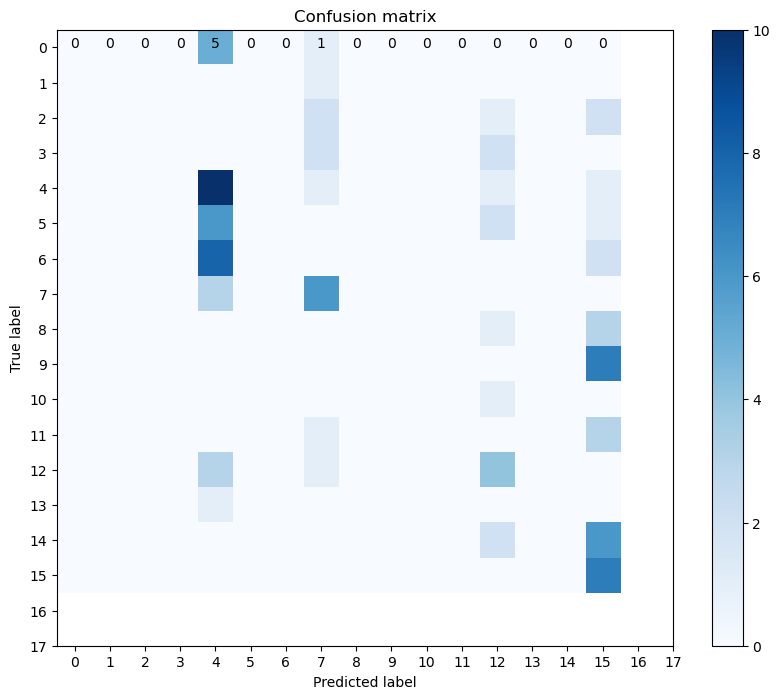

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(true, prediction)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = range(18)
plt.xticks(tick_marks, range(18))
plt.yticks(tick_marks, range(18))
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Display confusion matrix values
for i in range(18):
    for j in range(18):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.show()

# Print classification report for aggregate metrics
print(classification_report(true, prediction))

# Experiment 1


### Mode of Operation

* 321 verilog files 
* only 3 features             [type, operation_type, num_of_connections]
* no edge attribute
* 18 classes 
* 200 epochs 
* learning rate = 0.01
* Dropoout = 0.4
* Adam Optimizer
* train 70, test 30 (on whole dataset, not each class)
* time of training = seconds


### Results

* Train acc:  0.2902
* Test Acc: 0.1959


### Suggested Modifications for upcoming experiments

1) Clean dataset (by removing unnecessay, uninformative or wrong code files)
2) remove reduntant parsing (different files but same parsing)
3) include more informative features
4) improve encoding format
5) try using less classes (most important ones, so that less classes but more balanced dataset)
6) adding more files
7) adjusting hyperparameters such as learning rate, dropout, ...etc
8) splitting train, val, test
9) using equal percentages of each class (adjusting splitting)